##### source: https://www.onceupondata.com/2019/02/10/nn-collaborative-filtering/

In [ ]:
# import sys
# !{sys.executable} -m pip install numpy pandas matplotlib sklearn seaborn

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import zipfile
from urllib import request

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# sklearn imports
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# from tensorflow.keras.optimizers import Adagrad, Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

# import tensorflow as tf
# tf.debugging.set_log_device_placement(True)

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def download(url, filename):
    """Download a file if not present"""
    if not os.path.exists(filename):
        print("downloading {}...".format(filename))
        filename, _ = request.urlretrieve(url + filename, filename)

        print("extracting {}...".format(filename))
        with zipfile.ZipFile(filename) as f:
            f.extractall()
            print("extracting {} done".format(filename))

    """directory data"""
    data_path = filename.replace('.zip','')
    if not os.path.exists(data_path):
        print("extracting {}...".format(filename))
        with zipfile.ZipFile(filename) as f:
            f.extractall()
            print("extracting {} done".format(filename))

    """directory model for saving model while training"""
    if not os.path.exists('model'):
        os.mkdir('model')
        print("directory model created...")

In [3]:
# download dataset
download(url='https://github.com/kadriansyah/notebook/raw/master/', filename="data.zip")

##### Loading in data

In [4]:
def load_books():
    df = pd.read_csv('data/book-books.dat', sep=';', header=1, encoding="latin-1")
    df.columns = ['isbn', 'title', 'author', 'year_of_publication', 'publisher', 'image_url_s', 'image_url_m', 'image_url_l']
    
    # insert custom index for word embedding training
    df.insert(0, 'bid', range(1, len(df) + 1))
    return df[['bid','isbn','title','author','year_of_publication','publisher']]

def load_users():
    df = pd.read_csv('data/book-users.dat', sep=';', header=1, encoding="latin-1")
    df.columns=['user_id', 'location', 'age']
    
    # insert custom index for word embedding training
    df.insert(0, 'uid', range(1, len(df) + 1))
    return df[['uid','user_id','location','age']]

def load_ratings():
    df = pd.read_csv('data/book-ratings.dat', sep=';', header=1, encoding="latin-1")
    df.columns=['user_id', 'isbn', 'rating']
    return df[['user_id','isbn','rating']]

In [5]:
books = load_books()
books

,bid,isbn,title,author,year_of_publication,publisher
0,1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
1,2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
2,3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
3,4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
4,5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group
...,...,...,...,...,...,...
271354,271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
271355,271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books
271356,271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco
271357,271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press


In [6]:
users = load_users()
users

,uid,user_id,location,age
0,1,2,"stockton, california, usa",18.0
1,2,3,"moscow, yukon territory, russia",NaN
2,3,4,"porto, v.n.gaia, portugal",17.0
3,4,5,"farnborough, hants, united kingdom",NaN
4,5,6,"santa monica, california, usa",61.0
...,...,...,...,...
278852,278853,278854,"portland, oregon, usa",NaN
278853,278854,278855,"tacoma, washington, united kingdom",50.0
278854,278855,278856,"brampton, ontario, canada",NaN
278855,278856,278857,"knoxville, tennessee, usa",NaN


In [7]:
ratings = load_ratings()
ratings

,user_id,isbn,rating
0,276726,0155061224,5
1,276727,0446520802,0
2,276729,052165615X,3
3,276729,0521795028,6
4,276733,2080674722,0
...,...,...,...
1149774,276704,1563526298,9
1149775,276706,0679447156,0
1149776,276709,0515107662,10
1149777,276721,0590442449,10


In [8]:
# do some preprocessing to make sure data quality
ratings_clean_1 = ratings.merge(books, on='isbn', how='left', indicator=True)
ratings_clean_1 = ratings_clean_1[ratings_clean_1._merge != 'left_only']
ratings_clean_1 = ratings_clean_1.astype({'bid': 'int32'})
ratings_clean_1 = ratings_clean_1.drop(['_merge'], axis=1)
ratings_clean_1

,user_id,isbn,rating,bid,title,author,year_of_publication,publisher
0,276726,0155061224,5,225816,Rites of Passage,Judith Rae,2001,Heinle
1,276727,0446520802,0,11053,The Notebook,Nicholas Sparks,1996,Warner Books
2,276729,052165615X,3,246838,Help!: Level 1,Philip Prowse,1999,Cambridge University Press
3,276729,0521795028,6,246839,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press
4,276733,2080674722,0,123639,Les Particules Elementaires,Michel Houellebecq,1998,Flammarion
...,...,...,...,...,...,...,...,...
1149773,276704,0876044011,0,69543,Edgar Cayce on the Akashic Records: The Book o...,Kevin J. Todeschi,1998,A.R.E. Press (Association of Research &amp; Enlig
1149774,276704,1563526298,9,69544,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,2000,Longstreet Press
1149775,276706,0679447156,0,52540,Eight Weeks to Optimum Health: A Proven Progra...,Andrew Weil,1997,Alfred A. Knopf
1149776,276709,0515107662,10,15978,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996,Jove Books


In [9]:
# do some preprocessing to make sure data quality
ratings_clean_2 = ratings_clean_1.merge(users, on='user_id', how='left', indicator=True)
ratings_clean_2 = ratings_clean_2[ratings_clean_2.rating != 0]
ratings_clean_2 = ratings_clean_2.drop(['_merge'], axis=1)
ratings_clean_2

,user_id,isbn,rating,bid,title,author,year_of_publication,publisher,uid,location,age
0,276726,0155061224,5,225816,Rites of Passage,Judith Rae,2001,Heinle,276725,"seattle, washington, usa",NaN
2,276729,052165615X,3,246838,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,276728,"rijeka, n/a, croatia",16.0
3,276729,0521795028,6,246839,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,276728,"rijeka, n/a, croatia",16.0
5,276744,038550120X,7,9294,A Painted House,JOHN GRISHAM,2001,Doubleday,276743,"torrance, california, usa",NaN
12,276747,0060517794,9,4779,Little Altars Everywhere,Rebecca Wells,2003,HarperTorch,276746,"iowa city, iowa, usa",25.0
...,...,...,...,...,...,...,...,...,...,...,...
1031126,276704,0743211383,7,881,Dreamcatcher,Stephen King,2001,Scribner,276703,"cedar park, texas, usa",NaN
1031128,276704,0806917695,5,69541,Perplexing Lateral Thinking Puzzles: Scholasti...,Paul Sloane,1997,Sterling Publishing,276703,"cedar park, texas, usa",NaN
1031130,276704,1563526298,9,69544,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,2000,Longstreet Press,276703,"cedar park, texas, usa",NaN
1031132,276709,0515107662,10,15978,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996,Jove Books,276708,"mannington, west virginia, usa",38.0


In [10]:
num_users = len(ratings_clean_2.uid.unique())
num_items = len(ratings_clean_2.bid.unique())
print('There are {} unique users and {} unique books in this data set'.format(num_users, num_items))

There are 68091 unique users and 149836 unique books in this data set


In [11]:
user_max_id = users.uid.max()
book_max_id = books.bid.max()
print('There are {} distinct users in ratings and the max of uid is {}'.format(num_users, user_max_id))
print('There are {} distinct books in ratings and the max of bid is {}'.format(num_items, book_max_id))

There are 68091 distinct users in ratings and the max of uid is 278857
There are 149836 distinct books in ratings and the max of bid is 271359


In [12]:
train, test = train_test_split(ratings_clean_2, test_size=0.2, shuffle=True, random_state=99)
print('shape of training data set:')
print(train.shape)
print('shape of test data set:')
print(test.shape)

shape of training data set:
(307073, 11)
shape of test data set:
(76769, 11)


In [13]:
train.head()

,user_id,isbn,rating,bid,title,author,year_of_publication,publisher,uid,location,age
957059,254822,0670849448,8,74550,The Egyptian Jukebox: A Conundrum,Nick Bantock,1993,Penguin USA,254821,"hamilton, ontario, canada",NaN
761651,205943,0787963941,9,145155,Brand Asset Management : Driving Profitable Gr...,Scott M. Davis,2002,Jossey-Bass,205942,"boston, massachusetts, usa",43.0
305372,81368,0786862890,8,121260,Rock This!,Chris Rock,1997,Hyperion Books,81367,"mesa, arizona, usa",28.0
503316,135149,0553245503,7,51003,Bowdrie's Law,LOUIS L'AMOUR,1984,Bantam,135148,"ft. pierce, florida, usa",NaN
390669,104468,0671793535,6,9459,A Rose For Her Grave &amp; Other True Cases (A...,Ann Rule,1993,Pocket,104467,"mission, british columbia, canada",NaN


In [14]:
test.head()

,user_id,isbn,rating,bid,title,author,year_of_publication,publisher,uid,location,age
537284,144741,3548602908,6,233592,In den Armen der MÃ?ÃÂ¤nner. Roman.,Camille Laurens,2003,List Tb.,144740,"mannheim, baden-wuerttemberg, germany",36.0
1020474,273858,0937064076,7,51192,"8,000 Years of Wisdom (Book I)",Hua-Ching Ni,1983,Seven Star Communications,273857,"los angeles, california, usa",NaN
374812,99955,1562475150,7,3396,"Meet Josefina, an American Girl (American Girl...",Valerie Tripp,1997,Pleasant Company Publications,99954,"lockport, new york, usa",14.0
59309,14319,0553377876,9,1482,Half Asleep in Frog Pajamas,Tom Robbins,1995,Bantam,14318,"littleton, colorado, usa",NaN
424925,113661,0385425473,10,10794,Wild Swans: Three Daughters of China,JUNG CHANG,1992,Anchor,113660,"brownsville, california, usa",39.0


#### Creating Neural Network
<font size="3">Neural Networks proved there effectivness for almost every machine learning problem as of now and they also perform exceptionally well for recommendation systems.</font>

In [15]:
# define embeddingg size (similar for both users and books)
dim_embedddings = 50
bias = 1

# creating book embedding path
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(book_max_id+1, dim_embedddings, name="Book-Embedding")(book_input)
book_bias = Embedding(book_max_id+1, bias, name="Book-Bias")(book_input)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(user_max_id+1, dim_embedddings, name="User-Embedding")(user_input)
user_bias = Embedding(user_max_id+1, bias, name="User-Bias")(user_input)

matrix_product = Multiply()([book_embedding, user_embedding])
matrix_product = Dropout(0.2)(matrix_product)

input_terms = Concatenate()([matrix_product, user_bias, book_bias])
input_terms = Flatten()(input_terms)

# add fully-connected-layers
dense_1 = Dense(50, activation="relu", name = "Dense1")(input_terms)
dense_1 = Dropout(0.2)(dense_1)
dense_2 = Dense(20, activation="relu", name = "Dense2")(dense_1)
dense_2 = Dropout(0.2)(dense_2)
result = Dense(1, activation='relu', name='Activation')(dense_2)

# define model with 2 inputs and 1 output
model_mf = Model(inputs=[user_input, book_input], outputs=result)

# show model summary
model_mf.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Book-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Book-Embedding (Embedding)      (None, 1, 50)        13568000    Book-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 50)        13942900    User-Input[0][0]                 
______________________________________________________________________________________________

Num GPUs Available:  0
['/device:CPU:0', '/device:XLA_CPU:0']
Train on 305537 samples, validate on 1536 samples
Epoch 1/10
305537/305537 [==============================] - 17s 54us/sample - loss: 2.1859 - mean_absolute_error: 1.1660 - val_loss: 3.0120 - val_mean_absolute_error: 1.4067
Epoch 2/10
305537/305537 [==============================] - 16s 53us/sample - loss: 1.9451 - mean_absolute_error: 1.0977 - val_loss: 2.9845 - val_mean_absolute_error: 1.3971
Epoch 3/10
305537/305537 [==============================] - 16s 53us/sample - loss: 1.7512 - mean_absolute_error: 1.0400 - val_loss: 2.9664 - val_mean_absolute_error: 1.3926
Epoch 4/10
305537/305537 [==============================] - 16s 53us/sample - loss: 1.5988 - mean_absolute_error: 0.9921 - val_loss: 2.9242 - val_mean_absolute_error: 1.3780
Epoch 5/10
305537/305537 [==============================] - 16s 53us/sample - loss: 1.4752 - mean_absolute_error: 0.9516 - val_loss: 2.9119 - val_mean_absolute_error: 1.3736
Epoch 6/10
305537/

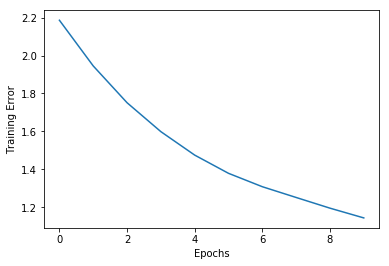

In [17]:
import tensorflow as tf
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(get_available_devices())

from tensorflow.keras.models import load_model
training = True

if not training and os.path.exists('model/regression_model_mf.h5'):
    model_mf = load_model('model/regression_model_mf.h5')
else:
    with tf.device('/device:CPU:0'):
        # specify learning rate (or use the default)
        opt_adam = Adam(lr = 0.002)

        # compile model
        model_mf.compile(optimizer=opt_adam, loss=['mse'], metrics=['mean_absolute_error'])

        # add call backs
        early_stopper = EarlyStopping(monitor='val_mean_absolute_error', patience=3, verbose=1)
        model_saver = ModelCheckpoint(
            filepath='model/regression_model_mf.h5',
            monitor='val_mean_absolute_error',
            save_best_only=True,
            save_weights_only=True)
        
        # fit model
        history_mf = model_mf.fit([train.uid, train.bid],
                                  train.rating,
                                  batch_size=4096,
                                  validation_split=0.005,
                                  epochs=10,
                                  verbose=1)
        plt.plot(history_mf.history['loss'])
        plt.xlabel("Epochs")
        plt.ylabel("Training Error")

In [18]:
with tf.device('/device:CPU:0'):
    print(model_mf.evaluate([test.uid, test.bid], test.rating))

76769/76769 [==============================] - 1s 17us/sample - loss: 2.8560 - mean_absolute_error: 1.3415
[2.855950135325138, 1.3415436]


In [19]:
predictions = model_mf.predict([test.uid.head(10), test.bid.head(10)])

[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[6.472774] 6
[6.445653] 7
[7.298933] 7
[6.9829144] 9
[8.538691] 10
[6.976952] 9
[8.191336] 9
[7.455543] 7
[7.281414] 9
[6.5679417] 7


[None, None, None, None, None, None, None, None, None, None]

#### Visualizing Embeddings
<font size="3">Embeddings are weights that are learned to represent some specific variable like books and user in our case and therefore we can not only use them to get good results on our problem but also to extract inside about our data.</font>

In [20]:
# Extract embeddings
book_em = model_mf.get_layer('Book-Embedding')
book_em_weights = book_em.get_weights()[0]

In [21]:
book_em_weights[:5]

array([[-0.0391549 ,  0.01156458, -0.04012467,  0.04355924,  0.00842569,
         0.03117234,  0.04799226,  0.02148925, -0.0350185 , -0.04053564,
        -0.01202518,  0.03153095, -0.04849594,  0.00710076,  0.02645815,
         0.03801339, -0.03201637,  0.04694789,  0.02167482,  0.03446842,
         0.0414041 , -0.01374988,  0.00664662, -0.03777274,  0.01333144,
         0.04491774,  0.00779997,  0.01546799, -0.01910636,  0.04098573,
        -0.01957222, -0.04743079,  0.02280292, -0.03130939,  0.00616863,
        -0.03020781, -0.03122494,  0.03322258, -0.00026719,  0.01148953,
         0.0134897 ,  0.04526042,  0.00136373,  0.0135552 ,  0.01910749,
         0.030723  ,  0.04813938,  0.01741851, -0.049256  , -0.02670606],
       [-0.09261356, -0.02397258,  0.01878853,  0.14415881, -0.12386816,
        -0.00800378,  0.07410071,  0.02638075,  0.00751455,  0.03469225,
         0.02277673,  0.04913733,  0.02384567, -0.03218557, -0.06584157,
        -0.02788023,  0.0370402 ,  0.1449746 ,  0.

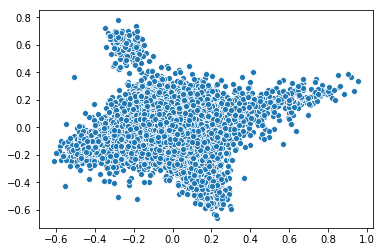

In [22]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [23]:
book_em_weights = book_em_weights / np.linalg.norm(book_em_weights, axis = 1).reshape((-1, 1))
book_em_weights[0][:10]
np.sum(np.square(book_em_weights[0]))

1.0

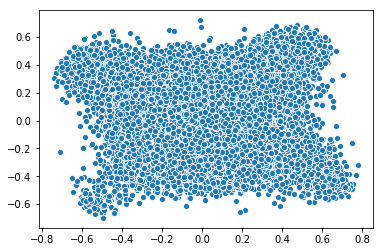

In [24]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [25]:
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
# tnse_results = tsne.fit_transform(book_em_weights)

In [26]:
# sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

#### Making Recommendations

In [27]:
# Creating dataset for making recommendations for the user
ratings_clean_2

,user_id,isbn,rating,bid,title,author,year_of_publication,publisher,uid,location,age
0,276726,0155061224,5,225816,Rites of Passage,Judith Rae,2001,Heinle,276725,"seattle, washington, usa",NaN
2,276729,052165615X,3,246838,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,276728,"rijeka, n/a, croatia",16.0
3,276729,0521795028,6,246839,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,276728,"rijeka, n/a, croatia",16.0
5,276744,038550120X,7,9294,A Painted House,JOHN GRISHAM,2001,Doubleday,276743,"torrance, california, usa",NaN
12,276747,0060517794,9,4779,Little Altars Everywhere,Rebecca Wells,2003,HarperTorch,276746,"iowa city, iowa, usa",25.0
...,...,...,...,...,...,...,...,...,...,...,...
1031126,276704,0743211383,7,881,Dreamcatcher,Stephen King,2001,Scribner,276703,"cedar park, texas, usa",NaN
1031128,276704,0806917695,5,69541,Perplexing Lateral Thinking Puzzles: Scholasti...,Paul Sloane,1997,Sterling Publishing,276703,"cedar park, texas, usa",NaN
1031130,276704,1563526298,9,69544,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,2000,Longstreet Press,276703,"cedar park, texas, usa",NaN
1031132,276709,0515107662,10,15978,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996,Jove Books,276708,"mannington, west virginia, usa",38.0


In [28]:
# user ratings
uid = 439
books_data = np.array(list(set(ratings_clean_2.bid)))
users_data = np.array([uid for i in range(len(books_data))])
ratings_clean_2[ratings_clean_2.uid == uid].sort_values(['rating'], ascending=[0])

,user_id,isbn,rating,bid,title,author,year_of_publication,publisher,uid,location,age
9253,440,0743424425,10,502,The Shining,Stephen King,2001,Pocket,439,"brookfield, wisconsin, usa",16.0
9252,440,0393321576,8,501,Karl Marx: A Life,Francis Wheen,2001,W.W. Norton &amp; Company,439,"brookfield, wisconsin, usa",16.0
9254,440,0786868015,7,503,The Diary of Ellen Rimbauer: My Life at Rose Red,Joyce Reardon,2001,Hyperion,439,"brookfield, wisconsin, usa",16.0


In [29]:
predictions = model_mf.predict([users_data, books_data])
predictions = np.array([a[0] for a in predictions])
recommended_book_ids = (-predictions).argsort()[:10]

recommendations = ratings_clean_2[ratings_clean_2['bid'].isin(recommended_book_ids)]
recommendations = recommendations.drop_duplicates(subset='title', keep="last")
recommendations.head(15)

,user_id,isbn,rating,bid,title,author,year_of_publication,publisher,uid,location,age
487941,130554,0448089491,7,81360,"The Bombay Boomerang (Hardy Boys, No 49)",Franklin W. Dixon,1970,Grosset &amp; Dunlap,130553,"sandpoint, idaho, usa",NaN
540915,145737,0962994235,6,32621,Your Body's Many Cries for Water,F. Batmanghelidj,1992,Global Health Solutions,145736,"elmhurst, illinois, usa",40.0
726434,197659,0141301147,6,32725,Danny the Champion of the World (Puffin Novels),Roald Dahl,1998,Puffin Books,197658,"indiana, pennsylvania, usa",49.0
884492,236994,0380974061,7,37864,Breach of Duty: A J.P. Beaumont Mystery,J.A. Jance,1999,William Morrow,236993,"seattle, washington, usa",NaN
894966,239594,0449245691,8,721,The Book of Lights,Chaim Potok,1997,Fawcett Books,239593,"leuven, vlaams-brabant, belgium",28.0
914766,244627,0312977409,8,12930,House of Dreams,Brenda Joyce,2001,St. Martin's Paperbacks,244626,"shelbyville, tennessee, usa",32.0
954846,254377,0689860242,9,54665,"Dragonsinger (Mccaffrey, Anne. Harper Hall Tri...",Anne McCaffrey,2003,Simon Pulse,254376,"niles, michigan, usa",50.0
1029593,276050,0671021001,9,485,She's Come Undone (Oprah's Book Club),Wally Lamb,1998,Pocket,276049,"beacon, new york, usa",30.0
